# ML face recognition

In [3]:
import cv2
import dlib
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

width = 50
height = 50
sz = (width, height)

## Generate the face dataset

Crop the dataset images of Berto Romero and Ignatius Farray so you can have square faces 50x50 pixels for train and test. The face detection is done using the Hog Face Detector.

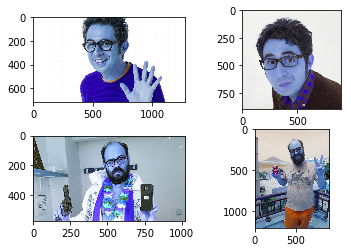

In [4]:
# Sample of faces not cropped

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.imread('img/not_cropped_faces/train/berto_romero1.jpg'))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(cv2.imread('img/not_cropped_faces/train/berto_romero2.jpg'))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(cv2.imread('img/not_cropped_faces/train/ignatius_farray1.jpg'))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(cv2.imread('img/not_cropped_faces/train/ignatius_farray2.jpg'))

In [6]:
def save_cropped_face(input_filename, output_filename):
    # read image
    image = cv2.imread(input_filename)
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces BB
    hogFaceDetector = dlib.get_frontal_face_detector()
    faceRects = hogFaceDetector(imageGray, 0)

    # draw faces BB
    for faceRect in faceRects:
        cv2.rectangle(image, (faceRect.left(), faceRect.top()), (faceRect.right(), faceRect.bottom()), (0, 255, 0), 2)
        h = faceRect.top()
        y = faceRect.bottom()
        x = faceRect.left()
        w = faceRect.right()

        crop_img = image[h:y, x:w]
        resized = cv2.resize(crop_img, sz, interpolation=cv2.INTER_AREA)
        gray_face = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

        cv2.imwrite(output_filename, gray_face)

    print('Processed image ' + input_filename)


def generate_face_dataset():
    for i in range(1, 11):
        input_filename = 'img/not_cropped_faces/train/berto_romero' + str(i) + '.jpg'
        output_filename = 'img/cropped_faces/train/berto_romero' + str(i) + '_cropped.jpg'

        save_cropped_face(input_filename, output_filename)

        input_filename = 'img/not_cropped_faces/train/ignatius_farray' + str(i) + '.jpg'
        output_filename = 'img/cropped_faces/train/ignatius_farray' + str(i) + '_cropped.jpg'

        save_cropped_face(input_filename, output_filename)

    for i in range(11, 16):
        input_filename = 'img/not_cropped_faces/test/berto_romero' + str(i) + '.jpg'
        output_filename = 'img/cropped_faces/test/berto_romero' + str(i) + '_cropped.jpg'

        save_cropped_face(input_filename, output_filename)

        input_filename = 'img/not_cropped_faces/test/ignatius_farray' + str(i) + '.jpg'
        output_filename = 'img/cropped_faces/test/ignatius_farray' + str(i) + '_cropped.jpg'

        save_cropped_face(input_filename, output_filename)

# Generate dataset of faces
generate_face_dataset()

Processed image img/not_cropped_faces/train/berto_romero1.jpg
Processed image img/not_cropped_faces/train/ignatius_farray1.jpg
Processed image img/not_cropped_faces/train/berto_romero2.jpg
Processed image img/not_cropped_faces/train/ignatius_farray2.jpg
Processed image img/not_cropped_faces/train/berto_romero3.jpg
Processed image img/not_cropped_faces/train/ignatius_farray3.jpg
Processed image img/not_cropped_faces/train/berto_romero4.jpg
Processed image img/not_cropped_faces/train/ignatius_farray4.jpg
Processed image img/not_cropped_faces/train/berto_romero5.jpg
Processed image img/not_cropped_faces/train/ignatius_farray5.jpg
Processed image img/not_cropped_faces/train/berto_romero6.jpg
Processed image img/not_cropped_faces/train/ignatius_farray6.jpg
Processed image img/not_cropped_faces/train/berto_romero7.jpg
Processed image img/not_cropped_faces/train/ignatius_farray7.jpg
Processed image img/not_cropped_faces/train/berto_romero8.jpg
Processed image img/not_cropped_faces/train/ignat

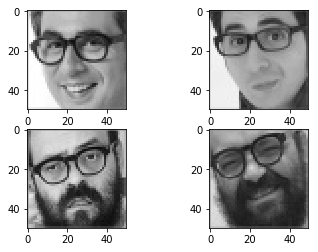

In [7]:
# Sample of cropped faces

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.imread('img/cropped_faces/train/berto_romero1_cropped.jpg'))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(cv2.imread('img/cropped_faces/train/berto_romero2_cropped.jpg'))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(cv2.imread('img/cropped_faces/train/ignatius_farray1_cropped.jpg'))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(cv2.imread('img/cropped_faces/train/ignatius_farray2_cropped.jpg'))

## Dimensionality Reduction with PCA

Now our face dataset is pre-processed. We have to reduce the dimensionality of the features that these images have. We will use PCA for it.

In [8]:
# Read the train and test images

def read_images():
    train_image_filenames = sorted(glob.glob("/Users/ericmassip/Projects/MAI/2nd_semester/CV/Assignment_3/img/cropped_faces/train/*.jpg"))
    test_image_filenames = sorted(glob.glob("/Users/ericmassip/Projects/MAI/2nd_semester/CV/Assignment_3/img/cropped_faces/test/*.jpg"))

    train_images = [process_image(image_filename) for image_filename in train_image_filenames]
    test_images = [process_image(image_filename) for image_filename in test_image_filenames]

    return train_images, test_images


def process_image(image_filename):
    image = cv2.imread(image_filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image.flatten()


train_images, test_images = read_images()

In [9]:
# Get matrix of images

def create_data_matrix(images):
    num_images = len(images)
    data = np.zeros((num_images, sz[0] * sz[1]), dtype=np.float32)
    for i in range(0, num_images):
        data[i, :] = images[i]

    return data


data = create_data_matrix(train_images)

In [34]:
def get_reconstructed_image(image, mean, eigenVectors):
    # Get the weights multiplying every eigenvector with the difference between the mean and the current image
    weights = get_weights(image, mean, eigenVectors)

    # Get the flattened reconstructed image multiplying every eigenvector with its respective weight and adding the mean
    reconstructed_image = np.add(mean, np.dot(weights, eigenVectors))

    return reconstructed_image

def get_weights(image, mean, eigenVectors):
    return np.dot(image - mean, np.transpose(eigenVectors))

Let's see how good the reconstruction is for a couple of images regarding the reconstruction error.

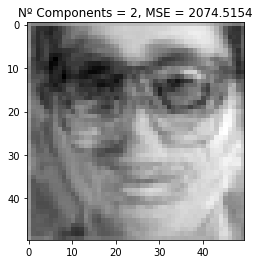

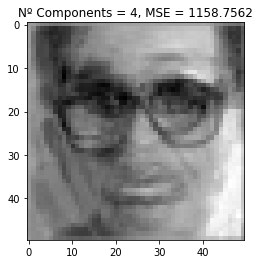

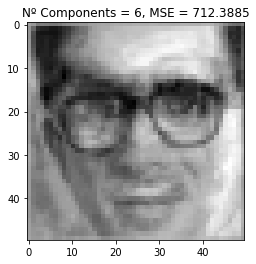

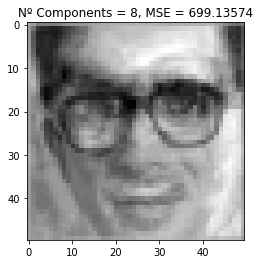

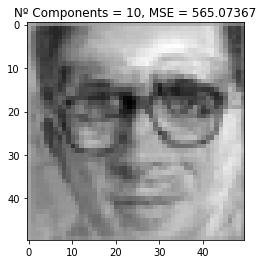

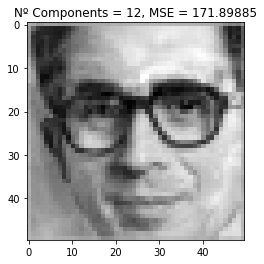

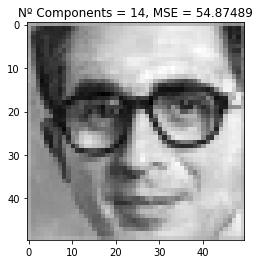

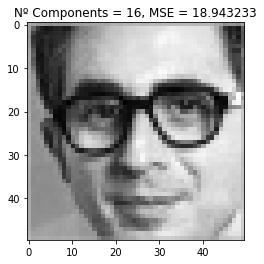

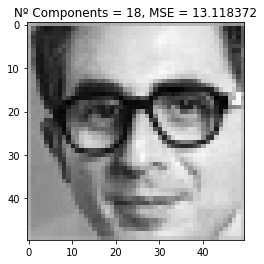

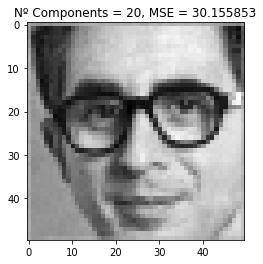

In [35]:
# Compute PCA Analysis

def plot_reconstructed_image(image, num_components):
    NUM_COMPONENTS = num_components
    mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_COMPONENTS)
    
    reconstructed_image = get_reconstructed_image(image, mean, eigenVectors)
    error = mean_squared_error(image, reconstructed_image.reshape(2500, ))
    
    plt.imshow(reconstructed_image.reshape(sz), cmap='gray')
    plt.title('Nº Components = ' + str(num_components) + ', MSE = ' + str(error))
    plt.show()
    

image = train_images[0]
for i in range(2, 21, 2):
    plot_reconstructed_image(image, i)

Another example but now with Ignatius

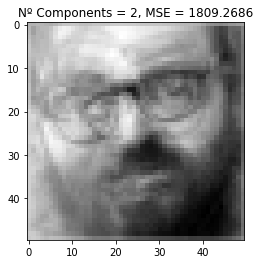

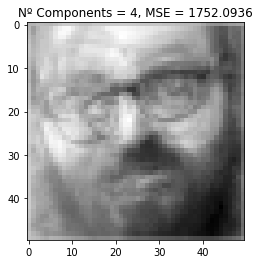

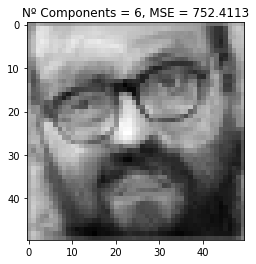

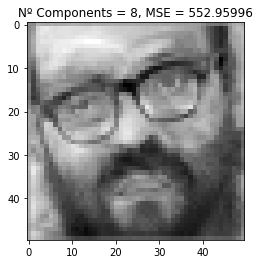

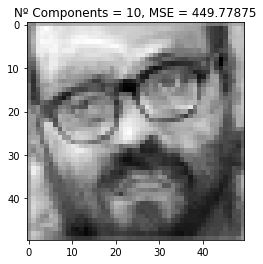

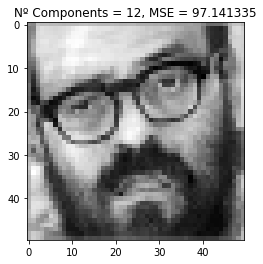

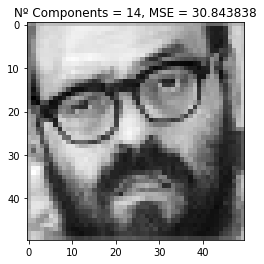

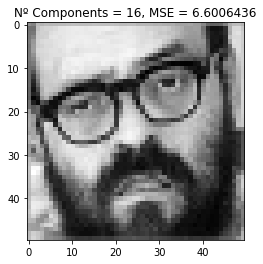

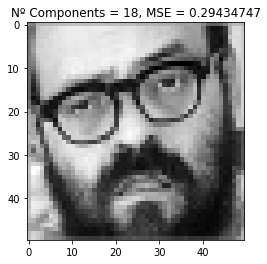

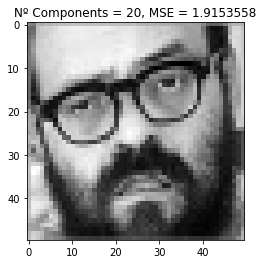

In [36]:
image = train_images[11]
for i in range(2, 21, 2):
    plot_reconstructed_image(image, i)

It looks like 12 components is quite good, although even half of that, hence 6 components, could be enough to differentiate between the two faces.

## Face-feature plot

For now, let's see the face-feature plot for the first 2 components, the most significant ones.

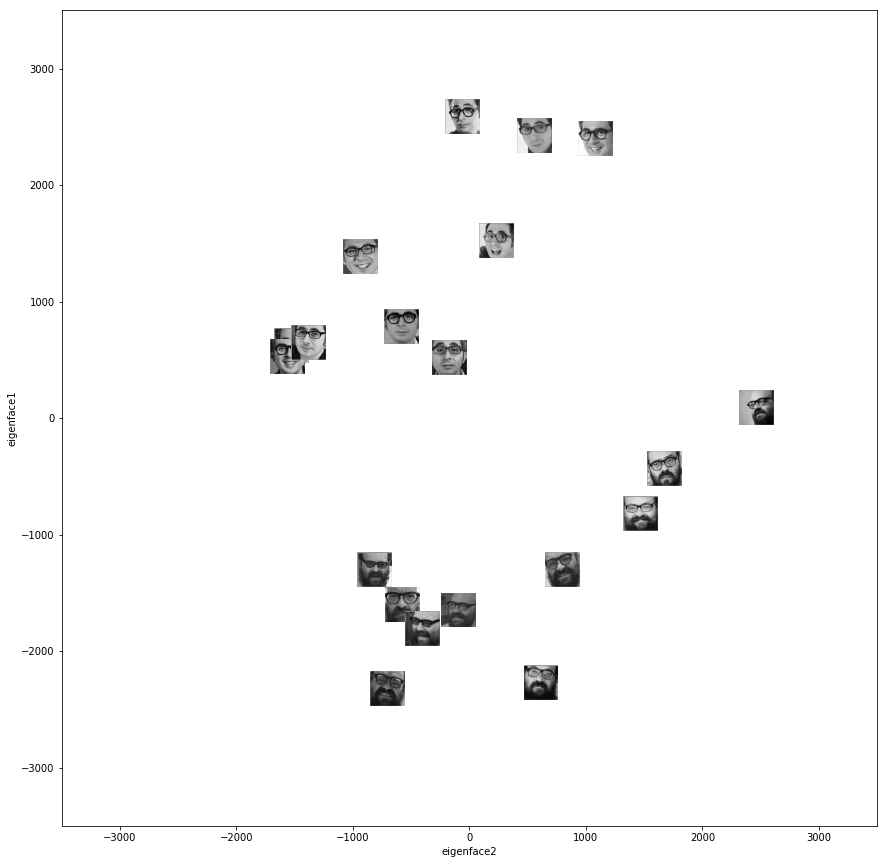

In [44]:
def plot_eigen2D(images, mean, eigenVectors):
    eigenfaces_plot = np.ones((7000, 7000))

    for image in images:
        weights = get_weights(image, mean, eigenVectors)

        x = np.round(-weights[0, 0] + 3500)
        y = np.round(weights[0, 1] + 3500)

        x1 = int(x - 150)
        x2 = int(x + 150)
        y1 = int(y - 150)
        y2 = int(y + 150)

        eigenfaces_plot[x1:x2, y1:y2] = cv2.resize(image.reshape(sz) / 255, None, fx=6, fy=6)

    plt.figure(figsize=(15,15))
    plt.imshow(eigenfaces_plot, cmap='gray', extent=[-3500, 3500, -3500, 3500])
    plt.xlabel("eigenface2")
    plt.ylabel("eigenface1")
    plt.show()

NUM_COMPONENTS = 2
mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_COMPONENTS)
    
plot_eigen2D(train_images, mean, eigenVectors)

The faces of Berto are on top-left side of the plot, the faces of Ignatius are on the bottom-right side of the plot, so it looks like it'll be enough with these first 2 components to classify new faces of them correctly.

## Face-feature plot with test images

Before proceeding with the classification, let's see how the face-feature plot looks like if we add the test images as well.

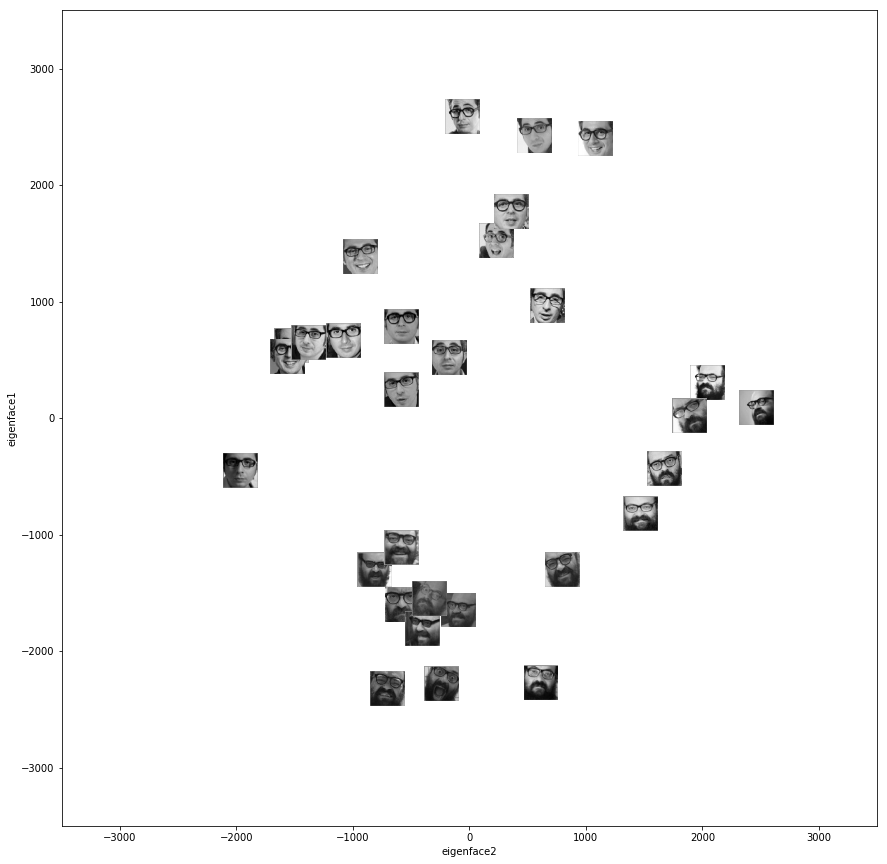

In [45]:
NUM_COMPONENTS = 2
mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_COMPONENTS)
    
plot_eigen2D(train_images + test_images, mean, eigenVectors)

It seems like the images of both classes are still well differentiated by these first 2 components.

## Classification

Now it's the time to see how good the classification can be using a few different Machine Learning methods.

### K-means

In [47]:
NUM_COMPONENTS = 2
mean, eigenVectors = cv2.PCACompute(data, mean=None, maxComponents=NUM_COMPONENTS)

X_train = np.array([get_weights(train_image, mean, eigenVectors).reshape(2) for train_image in train_images])
X_test = np.array([get_weights(test_image, mean, eigenVectors).reshape(2) for test_image in test_images])

# Classification using K-Means clustering
kmeans = KMeans(n_clusters=2).fit(X_train)

# Labels are set by the K-Means algorithm
Y_train = kmeans.labels_

# The first image belongs to Berto so if that is a 0,
# the first 5 labels of Y_test must be 0's, 1's otherwise
if Y_train[0] == 0:
    Y_test = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
else:
    Y_test = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

Y_pred = kmeans.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(Y_test, Y_pred)))

Accuracy: 1.0


### Linear SVM

In [48]:
clf = SVC(kernel='linear', gamma='auto')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(Y_test, Y_pred)))

Accuracy: 1.0


### Naive Bayes

In [49]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred = gnb.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(Y_test, Y_pred)))

Accuracy: 0.9


### K-NearestNeighbours

In [50]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, Y_train)
Y_pred = neigh.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(Y_test, Y_pred)))

Accuracy: 1.0
